In [ ]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
set.seed(1)
load_all("../../../hmmTMB")
source("markets_functions.R")  # adjust path if the notebook’s cwd differs


ℹ Loading hmmTMB


Warning message:
“Removed 3132 rows containing missing values or values outside the scale range
(`geom_line()`).”


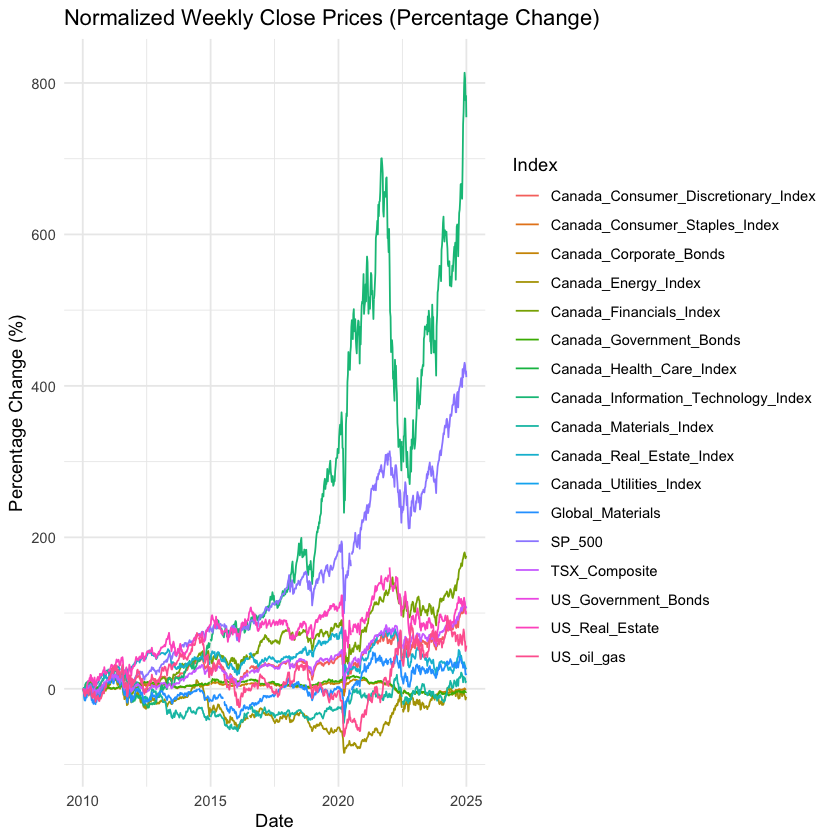

In [2]:

close_data <- get_markets_data("2010-01-01", "2025-01-01", "weeks")

# Reshape data for ggplot
close_data_long <- close_data %>%
  mutate(Date = rownames(close_data)) %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100) %>%  # Normalize as percentage change
  mutate(Date = as.Date(Date))

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

# Simple model for TSX only

In [54]:
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

splits <- train_test_split(data = close_data, perc = 0.8)
train_data <- splits$train
test_data <- splits$test
observation <- "TSX_Composite"

# Calculate percentage change for train_data
train_data_log <- ln_transform(train_data)
test_data_log <- ln_transform(test_data)

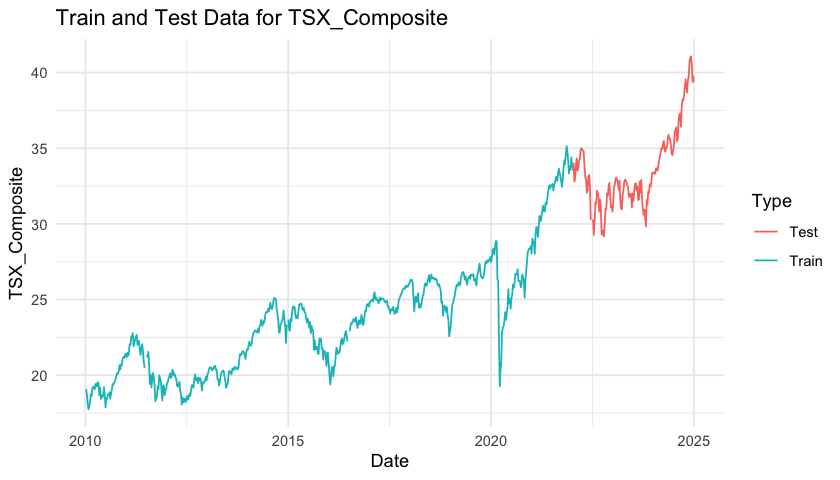

In [131]:
# Combine train_data and test_data for plotting
train_data$Type <- "Train"
test_data$Type <- "Test"
combined_data <- rbind(train_data, test_data)

# Plot train_data and test_data for TSX_Composite
options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
ggplot(combined_data, aes(x = as.Date(rownames(combined_data)), y = TSX_Composite, color = Type)) +
  geom_line() +
  labs(title = "Train and Test Data for TSX_Composite", x = "Date", y = "TSX_Composite") +
  theme_minimal()

In [100]:
fit_markets_hmm <- function(
    n_states,
    data,
    obs_name = "TSX_Composite",
    hid_formula = as.formula("~1")) 
  {
  hid_model <- hmmTMB::MarkovChain$new(
    data = data,
    n_states = n_states,
    formula = hid_formula,
    initial_state = "estimated",
    horseshoe = FALSE
  )

  obs_model <- hmmTMB::Observation$new(
    data = data,
    n_states = n_states,
    dists = setNames(list("norm"), obs_name),
    par = setNames(list(list(mean = seq(-0.1,0.1,length.out = n_states), sd = rep(0.1, n_states))), obs_name),
  )

  hmm <- hmmTMB::HMM$new(hid = hid_model, obs = obs_model)
  hmm$fit(silent = TRUE)
  hmm
}

Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”


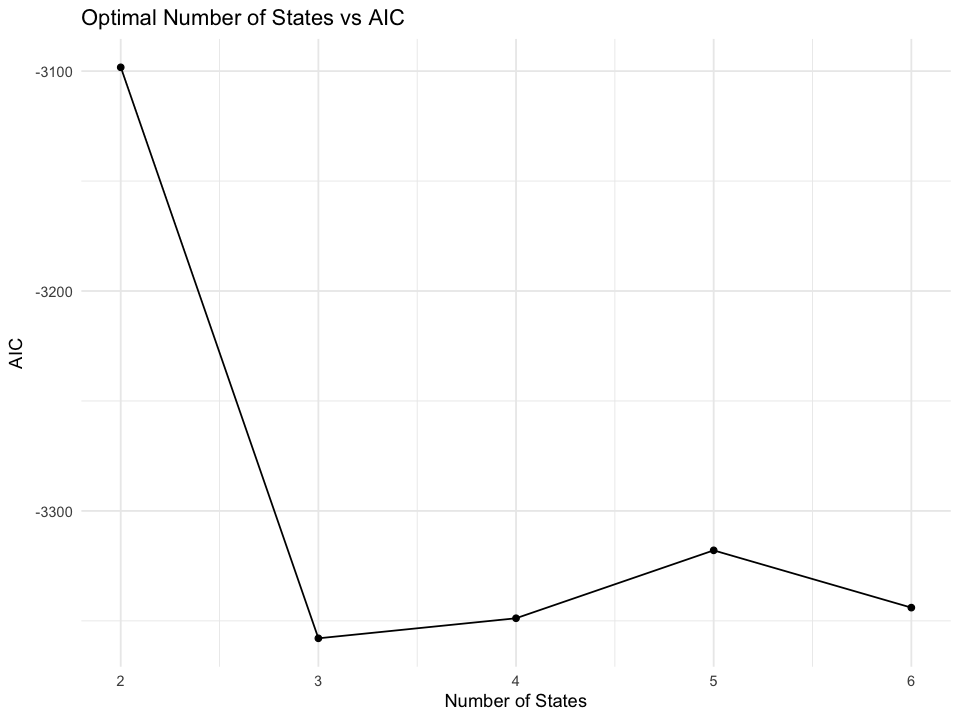

In [ ]:
optimal_n <- data.frame(
  n_states = integer(),
  AIC = numeric()
)
for (n in 2:6) {
  hmm <- fit_markets_hmm(n_states = n, data = train_data_log)
  optimal_n <- rbind(optimal_n, data.frame(n_states = n, AIC = hmm$AIC_conditional()))
}


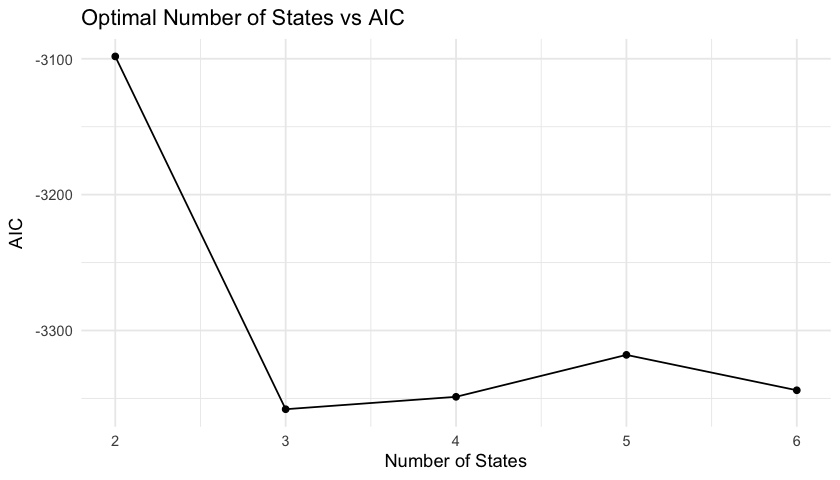

In [114]:
options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
ggplot(optimal_n, aes(x = n_states, y = AIC)) +
  geom_line() +
  geom_point() +
  labs(title = "Optimal Number of States vs AIC", x = "Number of States", y = "AIC") +
  theme_minimal()

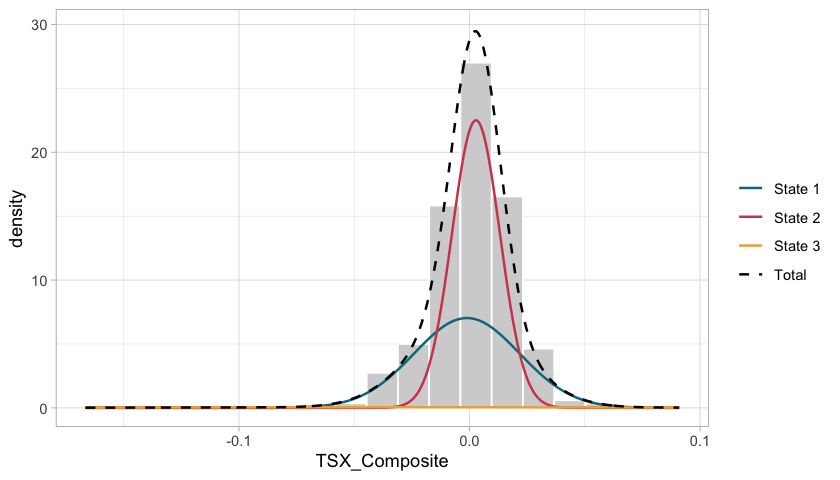

In [121]:
hmm <- fit_markets_hmm(n_states = 3, data = train_data_log)
hmm$plot_dist("TSX_Composite")

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


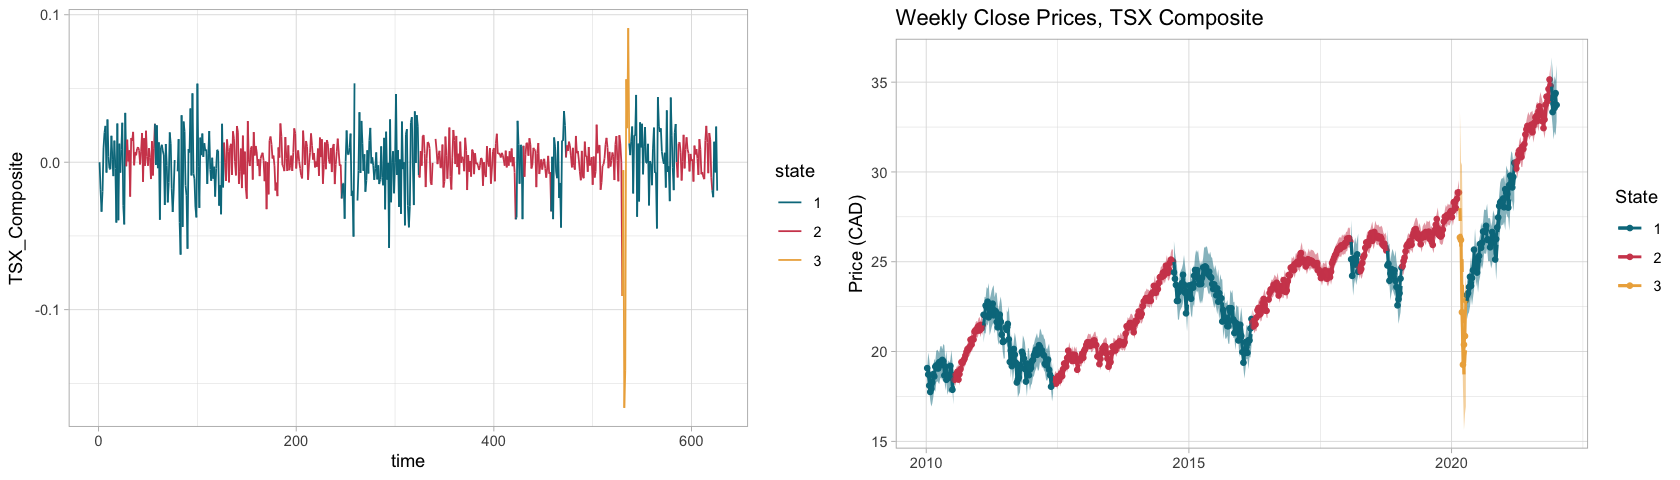

In [129]:
tsx_state <- prepare_tsx_state_data(train_data, hmm)
tsx_plot  <- plot_tsx_state_series(tsx_state, show = "both")
p <- hmm$plot_ts("TSX_Composite")

options(repr.plot.width = 14, repr.plot.height = 4)  # Adjust figure size
grid.arrange(p, tsx_plot, ncol = 2)

In [104]:
forecast <- hmmTMB::Forecast$new(
  hmm,
  n = 90,
  preset_eval_range = list(TSX_Composite=seq(-0.15, 0.15, by = 0.01))
)
forecast_dists <- forecast$forecast_dists()[[observation]]
forecast_dists_normalized <- sapply(seq_len(dim(forecast_dists)[2]), function(i) {
  forecast_dists[, i] / sum(forecast_dists[, i])
}, simplify = "array")
forecast_steps <- forecast$eval_range()[[observation]]
dim(forecast_dists)

[1] 31 90

In [106]:
hmm$print_obspar()

> Estimated observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.001   0.003  -0.031
TSX_Composite.sd     0.023   0.010   0.089



In [107]:
last_true_value <- tail(train_data[[observation]], n = 1)

real_forecast_probs <- array(0, dim = dim(forecast_dists_normalized))

first_step_probs <- forecast_dists_normalized[, 1]
real_forecast_probs[, 1] <- first_step_probs
current_step_probs <- first_step_probs
length_out <- length(forecast_steps)
for (i in 2:20) {
  current_step_probs <- convolve(current_step_probs, forecast_dists_normalized[, i], type = "open")
  start <- floor((length(current_step_probs) - length_out) / 2) + 1
  stop <- start + length(first_step_probs) - 1
  real_forecast_probs[, i] <- current_step_probs[start:stop]
}

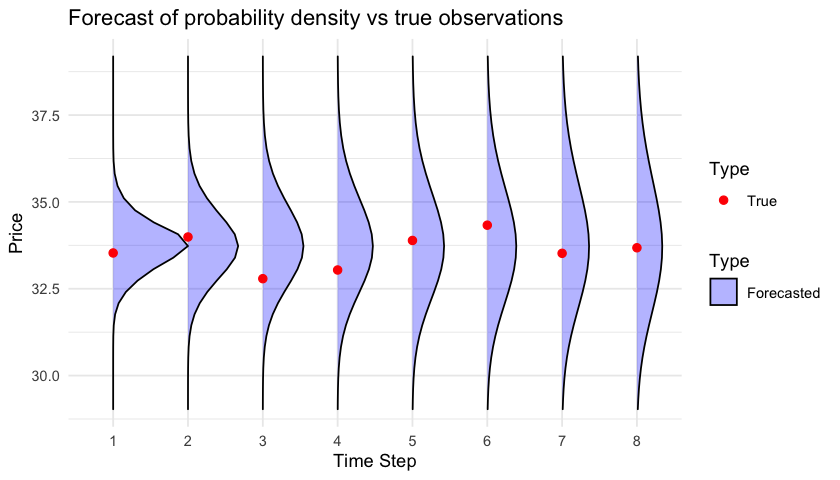

In [133]:
# Timesteps ahead to be plotted
forecast_timesteps <- c(1, 2, 3, 4, 5, 6, 7, 8)

scale_factor <- 1/max(real_forecast_probs[, 1])

real_range <- last_true_value * exp(forecast_steps)
ridge_data <- data.frame(
  x = rep(real_range, length(forecast_timesteps)),
  time = factor(rep(forecast_timesteps, each = length(real_range)), levels = forecast_timesteps),
  density = c(real_forecast_probs[, forecast_timesteps]*scale_factor)
)
true_df <- data.frame(
  time = factor(forecast_timesteps, levels = forecast_timesteps),
  x = test_data[[observation]][forecast_timesteps]
)

p <- ggplot() +
  geom_ridgeline(
    data = ridge_data,
    aes(x = x, y = time, height = density, fill = "Forecasted"),
    alpha = 0.3
  ) +
  geom_point(
    data = true_df,
    aes(x = x, y = time, colour = "True"),
    size = 2,
    inherit.aes = FALSE
  ) +
  scale_fill_manual(name = "Type", values = c("Forecasted" = "blue")) +
  scale_colour_manual(name = "Type", values = c("True" = "red")) +
  labs(
    title = "Forecast of probability density vs true observations",
    x = "Price",
    y = "Time Step"
  ) +
  theme_minimal() +
  guides(fill = guide_legend(override.aes = list(alpha = 0.3))) +
  # coord_cartesian(xlim = c(0, 10)) +
  coord_flip()

options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
p
